In [64]:
import numpy as np
import matplotlib.pyplot as plt

from torch import Tensor
from torch.nn import Linear, CrossEntropyLoss, MSELoss
from torch.optim import LBFGS

from qiskit  import Aer, QuantumCircuit
from qiskit.utils import QuantumInstance
from qiskit.opflow import AerPauliExpectation
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_machine_learning.neural_networks import CircuitQNN, TwoLayerQNN
from qiskit_machine_learning.connectors import TorchConnector

# Additional torch-related imports
from torch import cat, no_grad, manual_seed
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import torch.optim as optim
from torch.nn import (Module, Conv2d, Linear, Dropout2d, NLLLoss,
                     MaxPool2d, Flatten, Sequential, ReLU)
import torch.nn.functional as F

import sys
# insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, '/Users/trongduong/Dropbox/URP project/Code/PQC_Composer')
from utility.quantum_nn import  QuantumNeuralNetwork
from utility.ansatz_template import AnsatzTemplate
from utility.data_encoding import FeatureMap

In [43]:
# declare quantum instance
qi = QuantumInstance(Aer.get_backend('aer_simulator_statevector'))

In [44]:
# Train Dataset
# -------------

# Set train shuffle seed (for reproducibility)
manual_seed(1)

batch_size = 5
n_samples = 100 # We will concentrate on the first 100 samples

# Use pre-defined torchvision function to load MNIST train data
X_train = datasets.MNIST(root='./data', train=True, download=True,
                         transform=transforms.Compose([transforms.ToTensor()]))

# Filter out labels (originally 0-9), leaving only labels 0 and 1
idx = np.append(np.where(X_train.targets == 0)[0][:n_samples],
                np.where(X_train.targets == 1)[0][:n_samples])
X_train.data = X_train.data[idx]
X_train.targets = X_train.targets[idx]

# Define torch dataloader with filtered data
train_loader = DataLoader(X_train, batch_size=batch_size, shuffle=True)

In [69]:
type(train_loader)

torch.utils.data.dataloader.DataLoader

In [68]:
for batch_idx, (data, target) in enumerate(train_loader):
    print(data.shape,target.shape)

torch.Size([5, 1, 28, 28]) torch.Size([5])
torch.Size([5, 1, 28, 28]) torch.Size([5])
torch.Size([5, 1, 28, 28]) torch.Size([5])
torch.Size([5, 1, 28, 28]) torch.Size([5])
torch.Size([5, 1, 28, 28]) torch.Size([5])
torch.Size([5, 1, 28, 28]) torch.Size([5])
torch.Size([5, 1, 28, 28]) torch.Size([5])
torch.Size([5, 1, 28, 28]) torch.Size([5])
torch.Size([5, 1, 28, 28]) torch.Size([5])
torch.Size([5, 1, 28, 28]) torch.Size([5])
torch.Size([5, 1, 28, 28]) torch.Size([5])
torch.Size([5, 1, 28, 28]) torch.Size([5])
torch.Size([5, 1, 28, 28]) torch.Size([5])
torch.Size([5, 1, 28, 28]) torch.Size([5])
torch.Size([5, 1, 28, 28]) torch.Size([5])
torch.Size([5, 1, 28, 28]) torch.Size([5])
torch.Size([5, 1, 28, 28]) torch.Size([5])
torch.Size([5, 1, 28, 28]) torch.Size([5])
torch.Size([5, 1, 28, 28]) torch.Size([5])
torch.Size([5, 1, 28, 28]) torch.Size([5])
torch.Size([5, 1, 28, 28]) torch.Size([5])
torch.Size([5, 1, 28, 28]) torch.Size([5])
torch.Size([5, 1, 28, 28]) torch.Size([5])
torch.Size(

In [61]:
help(DataLoader)

Help on class DataLoader in module torch.utils.data.dataloader:

class DataLoader(typing.Generic)
 |  DataLoader(*args, **kwds)
 |  
 |  Data loader. Combines a dataset and a sampler, and provides an iterable over
 |  the given dataset.
 |  
 |  The :class:`~torch.utils.data.DataLoader` supports both map-style and
 |  iterable-style datasets with single- or multi-process loading, customizing
 |  loading order and optional automatic batching (collation) and memory pinning.
 |  
 |  See :py:mod:`torch.utils.data` documentation page for more details.
 |  
 |  Args:
 |      dataset (Dataset): dataset from which to load the data.
 |      batch_size (int, optional): how many samples per batch to load
 |          (default: ``1``).
 |      shuffle (bool, optional): set to ``True`` to have the data reshuffled
 |          at every epoch (default: ``False``).
 |      sampler (Sampler or Iterable, optional): defines the strategy to draw
 |          samples from the dataset. Can be any ``Iterable``

In [65]:
help(Dataset)

Help on class Dataset in module torch.utils.data.dataset:

class Dataset(typing.Generic)
 |  Dataset(*args, **kwds)
 |  
 |  An abstract class representing a :class:`Dataset`.
 |  
 |  All datasets that represent a map from keys to data samples should subclass
 |  it. All subclasses should overwrite :meth:`__getitem__`, supporting fetching a
 |  data sample for a given key. Subclasses could also optionally overwrite
 |  :meth:`__len__`, which is expected to return the size of the dataset by many
 |  :class:`~torch.utils.data.Sampler` implementations and the default options
 |  of :class:`~torch.utils.data.DataLoader`.
 |  
 |  .. note::
 |    :class:`~torch.utils.data.DataLoader` by default constructs a index
 |    sampler that yields integral indices.  To make it work with a map-style
 |    dataset with non-integral indices/keys, a custom sampler must be provided.
 |  
 |  Method resolution order:
 |      Dataset
 |      typing.Generic
 |      builtins.object
 |  
 |  Methods defined 

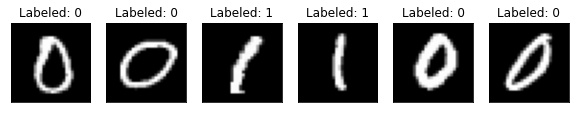

In [45]:
n_samples_show = 6

data_iter = iter(train_loader)
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

while n_samples_show > 0:
    images, targets = data_iter.__next__()

    axes[n_samples_show - 1].imshow(images[0, 0].numpy().squeeze(), cmap='gray')
    axes[n_samples_show - 1].set_xticks([])
    axes[n_samples_show - 1].set_yticks([])
    axes[n_samples_show - 1].set_title("Labeled: {}".format(targets[0].item()))

    n_samples_show -= 1

In [46]:
# Test Dataset
# -------------

# Set test shuffle seed (for reproducibility)
# manual_seed(5)

n_samples = 50

# Use pre-defined torchvision function to load MNIST test data
X_test = datasets.MNIST(root='./data', train=False, download=True,
                        transform=transforms.Compose([transforms.ToTensor()]))

# Filter out labels (originally 0-9), leaving only labels 0 and 1
idx = np.append(np.where(X_test.targets == 0)[0][:n_samples],
                np.where(X_test.targets == 1)[0][:n_samples])
X_test.data = X_test.data[idx]
X_test.targets = X_test.targets[idx]

# Define torch dataloader with filtered data
test_loader = DataLoader(X_test, batch_size=batch_size, shuffle=True)

In [58]:
help(TwoLayerQNN)

Help on class TwoLayerQNN in module qiskit_machine_learning.neural_networks.two_layer_qnn:

class TwoLayerQNN(qiskit_machine_learning.neural_networks.opflow_qnn.OpflowQNN)
 |  TwoLayerQNN(num_qubits: int = None, feature_map: qiskit.circuit.quantumcircuit.QuantumCircuit = None, ansatz: qiskit.circuit.quantumcircuit.QuantumCircuit = None, observable: Union[qiskit.opflow.operator_base.OperatorBase, NoneType] = None, exp_val: Union[qiskit.opflow.expectations.expectation_base.ExpectationBase, NoneType] = None, quantum_instance: Union[qiskit.providers.backend.Backend, qiskit.providers.basebackend.BaseBackend, qiskit.utils.quantum_instance.QuantumInstance, NoneType] = None, input_gradients: bool = False)
 |  
 |  Two Layer Quantum Neural Network consisting of a feature map, a ansatz,
 |  and an observable.
 |  
 |  Method resolution order:
 |      TwoLayerQNN
 |      qiskit_machine_learning.neural_networks.opflow_qnn.OpflowQNN
 |      qiskit_machine_learning.neural_networks.neural_network.Neu

In [47]:
feature_map = FeatureMap('PauliFeatureMap', feature_dim=2, reps=1)

template = AnsatzTemplate()
template.construct_simple_template(num_qubits=2, num_layers=3)

model = QuantumNeuralNetwork(feature_map, template, platform='Qiskit')

# REMEMBER TO SET input_gradients=True FOR ENABLING HYBRID GRADIENT BACKPROP
qnn4 = TwoLayerQNN(feature_map=model.feature_map_circ, ansatz=model.PQC, input_gradients=True, exp_val=AerPauliExpectation(), quantum_instance=qi)
print(qnn4.operator)

ComposedOp([
  OperatorMeasurement(1.0 * ZZ),
  CircuitStateFn(
       ┌─────────────────────────────┐»
  q_0: ┤0                            ├»
       │  PauliFeatureMap(x[0],x[1]) │»
  q_1: ┤1                            ├»
       └─────────────────────────────┘»
  «     ┌───────────────────────────────────────────────────────────────────────────────────────────────────────┐
  «q_0: ┤0                                                                                                      ├
  «     │  circuit-85388(θ[0],θ[1],θ[2],θ[3],θ[4],θ[5],θ[6],θ[7],θ[8],θ[9],θ[10],θ[11],θ[12],θ[13],θ[14],θ[15]) │
  «q_1: ┤1                                                                                                      ├
  «     └───────────────────────────────────────────────────────────────────────────────────────────────────────┘
  )
])


In [48]:
# Define torch NN module

class Net(Module):

    def __init__(self):
        super().__init__()
        self.conv1 = Conv2d(1, 2, kernel_size=5)
        self.conv2 = Conv2d(2, 16, kernel_size=5)
        self.dropout = Dropout2d()
        self.fc1 = Linear(256, 64)
        self.fc2 = Linear(64, 2)         # 2-dimensional input to QNN
        self.qnn = TorchConnector(qnn4)  # Apply torch connector, weights chosen
                                         # uniformly at random from interval [-1,1].
        self.fc3 = Linear(1, 1)          # 1-dimensional output from QNN

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.qnn(x)  # apply QNN
        x = self.fc3(x)
        return cat((x, 1 - x), -1)

model4 = Net()

In [49]:
# Define model, optimizer, and loss function
optimizer = optim.Adam(model4.parameters(), lr=0.001)
loss_func = NLLLoss()

# Start training
epochs = 10     # Set number of epochs
loss_list = []  # Store loss history
model4.train()  # Set model to training mode

for epoch in range(epochs):
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad(set_to_none=True)  # Initialize gradient
        output = model4(data)                  # Forward pass
        loss = loss_func(output, target)       # Calculate loss
        loss.backward()                        # Backward pass
        optimizer.step()                       # Optimize weights
        total_loss.append(loss.item())         # Store loss
    loss_list.append(sum(total_loss)/len(total_loss))
    print('Training [{:.0f}%]\tLoss: {:.4f}'.format(
        100. * (epoch + 1) / epochs, loss_list[-1]))

Training [10%]	Loss: -0.5305
Training [20%]	Loss: -0.6808
Training [30%]	Loss: -0.7607
Training [40%]	Loss: -0.8282
Training [50%]	Loss: -0.8959
Training [60%]	Loss: -0.9378
Training [70%]	Loss: -0.9933
Training [80%]	Loss: -1.0400
Training [90%]	Loss: -1.0820
Training [100%]	Loss: -1.1398


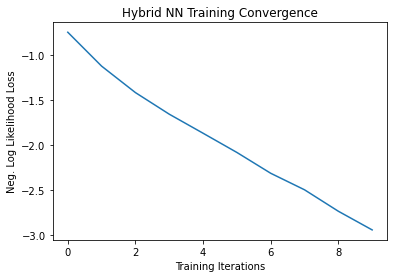

In [39]:
# Plot loss convergence
plt.plot(loss_list)
plt.title('Hybrid NN Training Convergence')
plt.xlabel('Training Iterations')
plt.ylabel('Neg. Log Likelihood Loss')
plt.show()

In [40]:
model4.eval()  # set model to evaluation mode
with no_grad():

    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model4(data)
        if len(output.shape) == 1:
            output = output.reshape(1, *output.shape)

        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()

        loss = loss_func(output, target)
        total_loss.append(loss.item())

    print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'
          .format(sum(total_loss) / len(total_loss),
                  correct / len(test_loader) / batch_size * 100)
    )

Performance on test data:
	Loss: -2.9795
	Accuracy: 100.0%


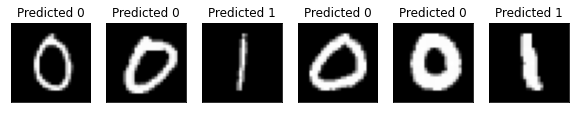

In [41]:
# Plot predicted labels

n_samples_show = 6
count = 0
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

model4.eval()
with no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        if count == n_samples_show:
            break
        output = model4(data[0:1])
        if len(output.shape) == 1:
            output = output.reshape(1, *output.shape)

        pred = output.argmax(dim=1, keepdim=True)

        axes[count].imshow(data[0].numpy().squeeze(), cmap='gray')

        axes[count].set_xticks([])
        axes[count].set_yticks([])
        axes[count].set_title('Predicted {}'.format(pred.item()))

        count += 1